In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
!unzip "/content/gdrive/MyDrive/Colab Notebooks/vit (2).zip" -d "/content/new1"

Streaming output truncated to the last 5000 lines.
  inflating: /content/new1/vit/vit/Dataset/Training/Healthy/Healthy721.png  
  inflating: /content/new1/vit/vit/Dataset/Training/Healthy/Healthy722.png  
  inflating: /content/new1/vit/vit/Dataset/Training/Healthy/Healthy723.png  
  inflating: /content/new1/vit/vit/Dataset/Training/Healthy/Healthy724.png  
  inflating: /content/new1/vit/vit/Dataset/Training/Healthy/Healthy725.png  
  inflating: /content/new1/vit/vit/Dataset/Training/Healthy/Healthy726.png  
  inflating: /content/new1/vit/vit/Dataset/Training/Healthy/Healthy727.png  
  inflating: /content/new1/vit/vit/Dataset/Training/Healthy/Healthy728.png  
  inflating: /content/new1/vit/vit/Dataset/Training/Healthy/Healthy729.png  
  inflating: /content/new1/vit/vit/Dataset/Training/Healthy/Healthy73.png  
  inflating: /content/new1/vit/vit/Dataset/Training/Healthy/Healthy730.png  
  inflating: /content/new1/vit/vit/Dataset/Training/Healthy/Healthy731.png  
  inflating: /content/new1

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms



In [ ]:
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

class_names = ['Healthy','Parkinson']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 57.0MB/s]


In [ ]:
!pip install torchinfo

import torchinfo
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(64, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [64, 3, 224, 224]    [64, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [64, 3, 224, 224]    [64, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [64, 197, 768]       [64, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [64, 197, 768]       [64, 197, 768]       --                   --
│    └─Sequential (layers)                                   [64, 197, 768]       [64, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [64, 197, 768]       [64, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [64, 197, 768]       [64, 

In [ ]:
train_dir = '/content/new1/vit/vit/NEW-PARKINSONS-DATASET/Training'
test_dir = '/content/new1/vit/vit/NEW-PARKINSONS-DATASET/Testing'

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  #train_data = datasets.ImageFolder(train_dir, transform=transform)
  #test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [ ]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,


                                                                                          test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [ ]:

os.chdir('/content/new1/vit/vit/going_modular')  # Replace with the correct path


In [ ]:
from going_modular import engine


In [ ]:
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()
#Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=7,
                                      device=device)


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4593 | train_acc: 0.7704 | test_loss: 0.4190 | test_acc: 0.8041
Epoch: 2 | train_loss: 0.3822 | train_acc: 0.8184 | test_loss: 0.3909 | test_acc: 0.8109
Epoch: 3 | train_loss: 0.3529 | train_acc: 0.8348 | test_loss: 0.3658 | test_acc: 0.8337
Epoch: 4 | train_loss: 0.3338 | train_acc: 0.8428 | test_loss: 0.3513 | test_acc: 0.8352
Epoch: 5 | train_loss: 0.3215 | train_acc: 0.8595 | test_loss: 0.3322 | test_acc: 0.8488
Epoch: 6 | train_loss: 0.3000 | train_acc: 0.8710 | test_loss: 0.3291 | test_acc: 0.8324
Epoch: 7 | train_loss: 0.3018 | train_acc: 0.8646 | test_loss: 0.3180 | test_acc: 0.8751


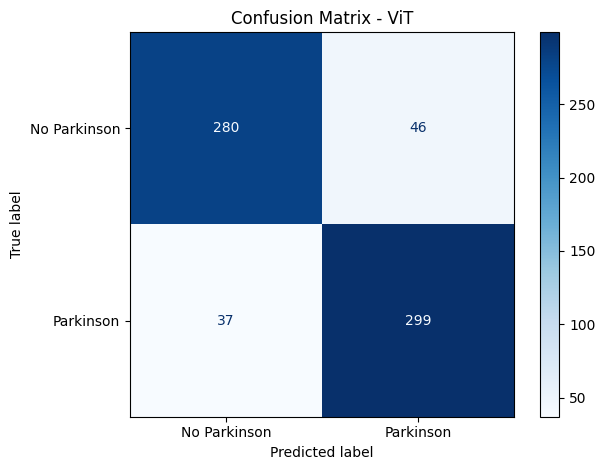


Accuracy: 0.8746


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

cm_VIT = confusion_matrix(all_labels, all_preds)

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)


# Plot the confusion matrix for ResNet
disp_VIT = ConfusionMatrixDisplay(confusion_matrix=cm_VIT, display_labels=["No Parkinson", "Parkinson"])
disp_VIT.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - ViT")
plt.grid(False)

# If you are using plt.show() to display the figure, you may use plt.tight_layout() before plt.show()
plt.tight_layout()
plt.show()
print()
print(f"Accuracy: {accuracy:.4f}")


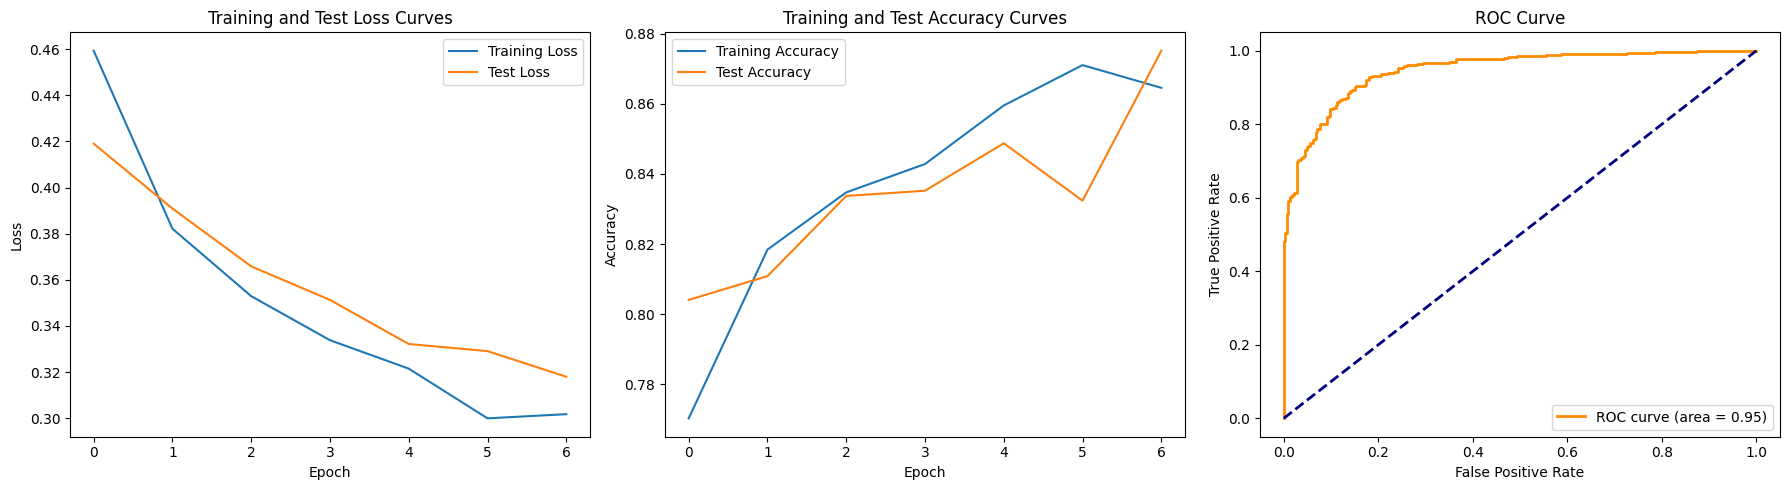

In [ ]:
import matplotlib.pyplot as plt
from going_modular import engine
import torch
from sklearn.metrics import accuracy_score, roc_curve, auc

# Initialize empty lists to store training and test metrics
train_loss_values = []
train_accuracy_values = []
test_loss_values = []
test_accuracy_values = []

# Retrieve loss and accuracy values
train_loss_values = pretrained_vit_results["train_loss"]
train_accuracy_values = pretrained_vit_results["train_acc"]
test_loss_values = pretrained_vit_results["test_loss"]
test_accuracy_values = pretrained_vit_results["test_acc"]

# Calculate and plot the ROC curve
with torch.no_grad():
    all_probs = []
    all_labels = []

    for inputs, labels in test_dataloader_pretrained:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = pretrained_vit(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot both loss, accuracy, and ROC curves side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot the loss curve
axes[0].plot(train_loss_values, label='Training Loss')
axes[0].plot(test_loss_values, label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Test Loss Curves')
axes[0].legend()

# Plot the accuracy curve
axes[1].plot(train_accuracy_values, label='Training Accuracy')
axes[1].plot(test_accuracy_values, label='Test Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Test Accuracy Curves')
axes[1].legend()

# Plot the ROC curve
axes[2].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('ROC Curve')
axes[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save the entire model
torch.save(pretrained_vit, 'pretrained_vit_model.pth')
